# Streaming SD - ami mixheadset 

### tuned HP DER 25% 1.5s latency
### Default DER 46.4% for 0.5s latency and 42.6% for 5s latency

- Runs on very low RAM (\~1GB) as opposed to NeMo or pyannote (\~10GB)
- Realtime diarization with metrics
- easy setup
- can be used for almost infintite audio stream, unlike other models which need smaller audio files
- TODO: training


In [16]:

# install pyannote and other dependencies as well from https://github.com/juanmc2005/StreamingSpeakerDiarization
# !pip install diart
# !pip install pyannote.audio


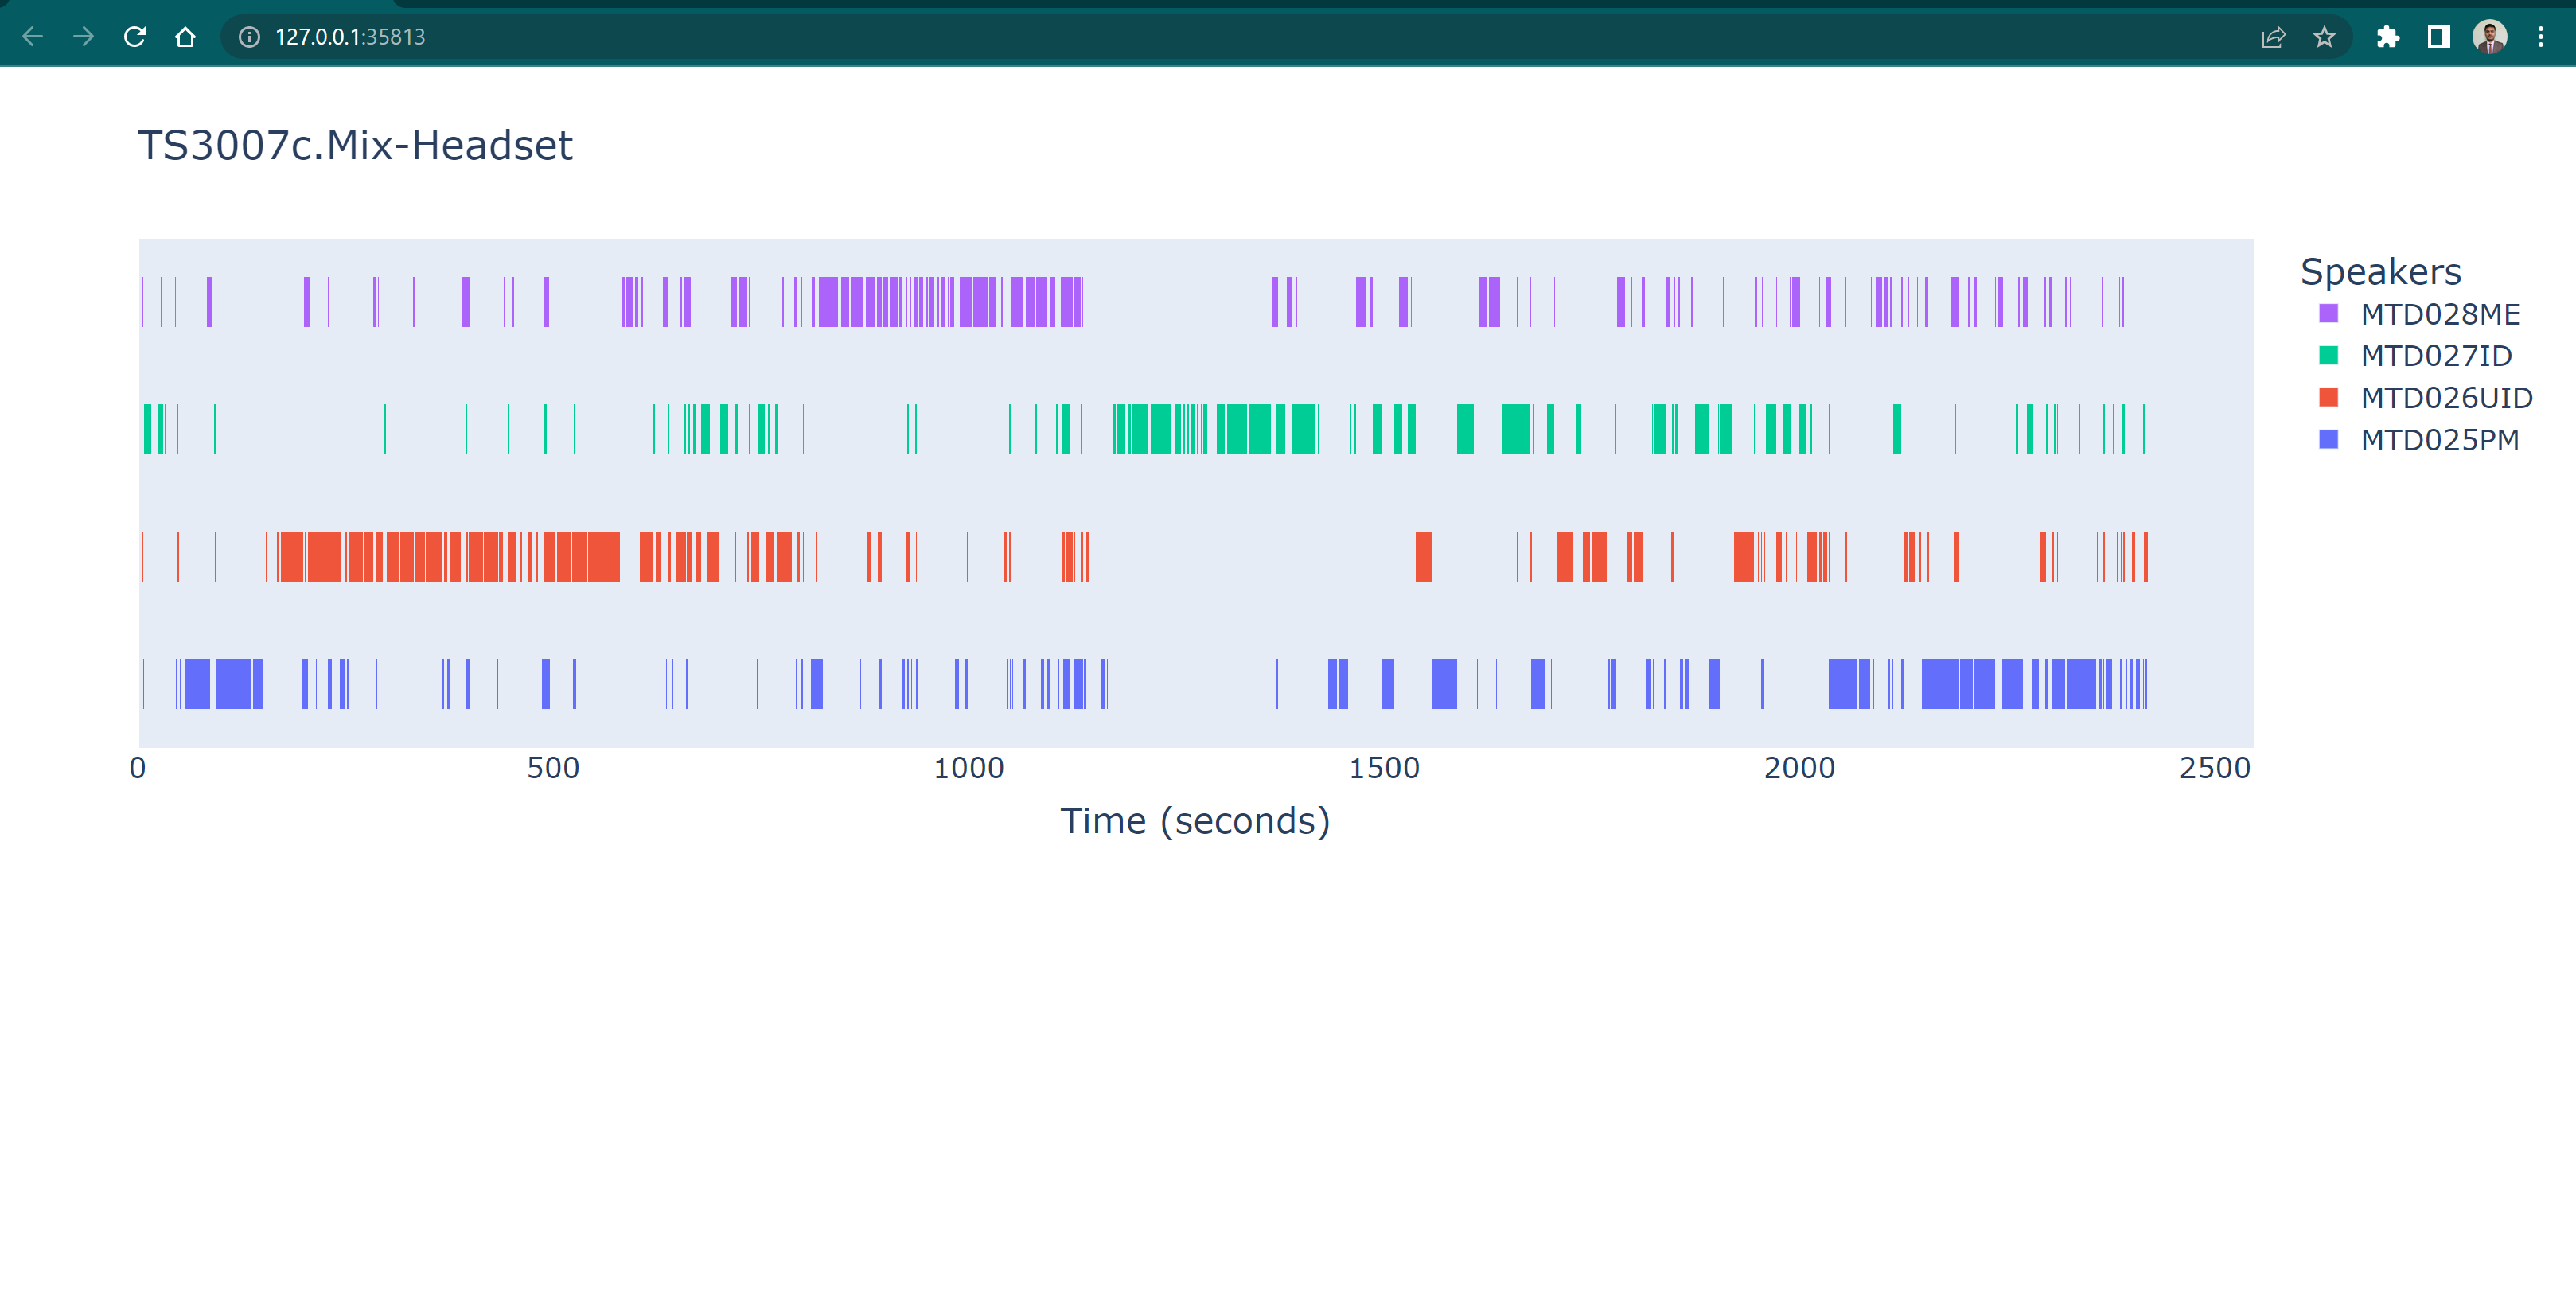

<img src="rttm-viewer-demo-AMI.gif" width="750" align="center">

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# CUDA_VISIBLE_DEVICES options = 0/1/2/3. Make sure to restart
!echo $CUDA_VISIBLE_DEVICES

1


In [2]:
import os
import glob
import pandas as pd
import numpy as np
import IPython
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.database.util import load_rttm

from diart.sources import MicrophoneAudioSource, FileAudioSource
from diart.inference import RealTimeInference
from diart.pipelines import OnlineSpeakerDiarization, PipelineConfig
# Benchmark
from diart.inference import Benchmark



/root/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'data/ami_mix_headset')
os.makedirs(data_dir, exist_ok=True)
print("ROOT: ", ROOT)
print("Data Directory: ", data_dir)
      
audio_filepath = '/home/DATA/amit_kesari/AMI-diarization-setup/pyannote/amicorpus/'
groundtruth_rttm_filepath = os.path.join(data_dir, 'rttms')
print(groundtruth_rttm_filepath)
# has a train,dev,test subdir

if not os.path.exists(audio_filepath):
    print("Please give correct audio location. No ", audio_filepath)
if not os.path.exists(groundtruth_rttm_filepath):
    print("Please give correct rttm groundtruth location. No ", groundtruth_rttm_filepath)

    
test_type = 'test'


groundtruth_rttm_list = []
if test_type == 'test':
    # small test dataset
    groundtruth_rttm_list = glob.glob(groundtruth_rttm_filepath + '/test/*.rttm', recursive=True)
    for test_path in groundtruth_rttm_list:
        print(test_path)
elif test_type == 'train':
    groundtruth_rttm_list = glob.glob(groundtruth_rttm_filepath + '/train/*.rttm', recursive=True)
    for test_path in groundtruth_rttm_list:
        print(test_path)


!find {audio_filepath} -iname "*.wav" > {data_dir}/train_all.txt

audio_list = []
with open(data_dir+'/train_all.txt') as data:
    audio_list.append(data.read().split())
audio_list = audio_list[0]
audio_list

ROOT:  /home/DATA/amit_kesari/SD1/diart
Data Directory:  /home/DATA/amit_kesari/SD1/diart/data/ami_mix_headset
/home/DATA/amit_kesari/SD1/diart/data/ami_mix_headset/rttms
/home/DATA/amit_kesari/SD1/diart/data/ami_mix_headset/rttms/test/EN2002a.Mix-Headset.rttm
/home/DATA/amit_kesari/SD1/diart/data/ami_mix_headset/rttms/test/EN2002b.Mix-Headset.rttm
/home/DATA/amit_kesari/SD1/diart/data/ami_mix_headset/rttms/test/EN2002c.Mix-Headset.rttm
/home/DATA/amit_kesari/SD1/diart/data/ami_mix_headset/rttms/test/EN2002d.Mix-Headset.rttm
/home/DATA/amit_kesari/SD1/diart/data/ami_mix_headset/rttms/test/ES2004a.Mix-Headset.rttm
/home/DATA/amit_kesari/SD1/diart/data/ami_mix_headset/rttms/test/ES2004b.Mix-Headset.rttm
/home/DATA/amit_kesari/SD1/diart/data/ami_mix_headset/rttms/test/ES2004c.Mix-Headset.rttm
/home/DATA/amit_kesari/SD1/diart/data/ami_mix_headset/rttms/test/ES2004d.Mix-Headset.rttm
/home/DATA/amit_kesari/SD1/diart/data/ami_mix_headset/rttms/test/IS1009a.Mix-Headset.rttm
/home/DATA/amit_kes

['/home/DATA/amit_kesari/AMI-diarization-setup/pyannote/amicorpus/ES2002a/audio/ES2002a.Mix-Headset.wav',
 '/home/DATA/amit_kesari/AMI-diarization-setup/pyannote/amicorpus/ES2002b/audio/ES2002b.Mix-Headset.wav',
 '/home/DATA/amit_kesari/AMI-diarization-setup/pyannote/amicorpus/ES2002c/audio/ES2002c.Mix-Headset.wav',
 '/home/DATA/amit_kesari/AMI-diarization-setup/pyannote/amicorpus/ES2002d/audio/ES2002d.Mix-Headset.wav',
 '/home/DATA/amit_kesari/AMI-diarization-setup/pyannote/amicorpus/ES2003a/audio/ES2003a.Mix-Headset.wav',
 '/home/DATA/amit_kesari/AMI-diarization-setup/pyannote/amicorpus/ES2003b/audio/ES2003b.Mix-Headset.wav',
 '/home/DATA/amit_kesari/AMI-diarization-setup/pyannote/amicorpus/ES2003c/audio/ES2003c.Mix-Headset.wav',
 '/home/DATA/amit_kesari/AMI-diarization-setup/pyannote/amicorpus/ES2003d/audio/ES2003d.Mix-Headset.wav',
 '/home/DATA/amit_kesari/AMI-diarization-setup/pyannote/amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav',
 '/home/DATA/amit_kesari/AMI-diarization-setup

In [4]:

def convert_ami_base():
    # base name of audio file and refernce rttm file should be same!
    # Eg: TS3003a.rttm -> TS3003a.Mix-Headset.rttm
    groundtruth_rttm_list = glob.glob(groundtruth_rttm_filepath + '/train/*.rttm', recursive=True)
    for test_path in groundtruth_rttm_list:
        new_test_path = test_path[:-5]+".Mix-Headset.rttm"
        !mv {test_path} {new_test_path}
        print("new ", new_test_path)

        
        
## RUN ONLY ONCE! Convert rttm to same AMI base name
# convert_ami_base()

# One shot method of benchmark

In [7]:
# Benchmark from diart
%matplotlib notebook

wav_dir = os.path.join(data_dir,'wav/test')
rttm_dir = os.path.join(data_dir, 'rttms/test')
out_dir = os.path.join(data_dir, 'out')
print(f"wav_dir: {wav_dir}\nrttm_dir: {rttm_dir}\nout_dir: {out_dir}")

# base_config = PipelineConfig(
#     step=0.5,
#     latency=0.5,
#     tau_active=0.507,
#     rho_update=0.006,
#     delta_new=1.057
# )

# got after traing and tuning hyperparamters on AMI
config = PipelineConfig(
    step=0.5,
    latency=1.5,
    tau_active=0.667,
    rho_update=0.976,
    delta_new=0.75
)

pipeline = OnlineSpeakerDiarization(config)

benchmark = Benchmark(wav_dir, rttm_dir, out_dir, show_report=True, batch_size=64)

benchmark(pipeline)

wav_dir: /home/DATA/amit_kesari/SD1/diart/data/ami_mix_headset/wav/test
rttm_dir: /home/DATA/amit_kesari/SD1/diart/data/ami_mix_headset/rttms/test
out_dir: /home/DATA/amit_kesari/SD1/diart/data/ami_mix_headset/out


Pre-calculating EN2002c.Mix-Headset (3/16):  42%|████▏     | 39/93 [00:04<00:07,  7.50batch/s]


Pre-calculating ES2004b.Mix-Headset (6/16):   8%|▊         | 6/74 [00:00<00:08,  8.36batch/s]


Pre-calculating ES2004d.Mix-Headset (8/16):  31%|███▏      | 22/70 [00:02<00:05,  8.68batch/s]


Pre-calculating IS1009c.Mix-Headset (11/16):  39%|███▊      | 22/57 [00:02<00:04,  8.69batch/s]


Pre-calculating TS3003b.Mix-Headset (14/16):  25%|██▍       | 17/69 [00:02<00:06,  8.62batch/s]


Pre-calculating TS3003d.Mix-Headset (16/16):  34%|███▍      | 28/82 [00:03<00:06,  8.41batch/s]


Pre-calculating TS3003d.Mix-Headset (16/16):  99%|█████████▉| 81/82 [00:09<00:00,  8.67batch/s]


        diarization error rate    total  correct correct false alarm false alarm missed detection missed detection confusion confusion
                             %                         %                       %                                 %                   %
item                                                                                                                                  
EN2002a                  33.13  2530.26  1726.13   68.22       34.11        1.35           608.72            24.06    195.40      7.72
EN2002b                  33.59  1943.44  1323.16   68.08       32.47        1.67           434.41            22.35    185.87      9.56
EN2002c                  28.22  3343.64  2421.30   72.42       21.36        0.64           704.86            21.08    217.48      6.50
EN2002d                  37.68  2675.89  1704.18   63.69       36.50        1.36           738.53            27.60    233.19      8.71
ES2004a                  29.23   923.43   666.11   72.1

diarization error rate      total    correct            false alarm  \
                             %                                %               
item                                                                          
EN2002a              33.128453   2530.260   1726.132  68.219551      34.108   
EN2002b              33.587556   1943.440   1323.160  68.083399      32.474   
EN2002c              28.223762   3343.640   2421.303  72.415182      21.364   
EN2002d              37.677707   2675.890   1704.176  63.686325      36.500   
ES2004a              29.225929    923.430    666.112  72.134542      12.563   
ES2004b              14.991066   2233.050   1944.649  87.084884      46.357   
ES2004c              18.807558   2244.470   1891.295  84.264659      68.955   
ES2004d              22.105872   2006.770   1628.802  81.165355      65.646   
IS1009a              27.427360    695.900    522.550  75.089812      17.517   
IS1009b              16.716642   1982.970   1681.978  84.821152      30.494   
IS1009c              12.835369   1584.450   1419.295  89.576509      38.215   
IS1009d              27.305246   1738.600   1305.326  75.079144      41.455   
TS3003a              25.816305   1025.964    779.858  76.012219      18.760   
TS3003b              15.135238   1820.500   1603.006  88.053062      58.043   
TS3003c              27.487290   1894.250   1427.545  75.362017      53.973   
TS3003d              29.434344   2070.340   1513.239  73.091328      52.290   
TOTAL                25.344245  30713.924  23558.426  76.702755     628.714   

                  missed detection            confusion             
                %                           %                    %  
item                                                                
EN2002a  1.348004          608.724  24.057765   195.404   7.722685  
EN2002b  1.670955          434.408  22.352530   185.872   9.564072  
EN2002c  0.638944          704.862  21.080679   217.475   6.504139  
EN2002d  1.364032          738.527  27.599303   233.187   8.714372  
ES2004a  1.360471          188.247  20.385627    69.071   7.479831  
ES2004b  2.075950          243.242  10.892815    45.159   2.022301  
ES2004c  3.072217          203.360   9.060491   149.815   6.674850  
ES2004d  3.271227          297.009  14.800351    80.959   4.034294  
IS1009a  2.517172          110.278  15.846817    63.072   9.063371  
IS1009b  1.537794          225.214  11.357408    75.778   3.821440  
IS1009c  2.411878           99.808   6.299221    65.347   4.124270  
IS1009d  2.384390          238.346  13.709076   194.928  11.211780  
TS3003a  1.828524          192.336  18.746857    53.770   5.240925  
TS3003b  3.188300          156.694   8.607196    60.800   3.339742  
TS3003c  2.849307          228.787  12.077973   237.918  12.560011  
TS3003d  2.525672          410.085  19.807616   147.016   7.101056  
TOTAL    2.047000         5079.927  16.539492  2075.571   6.757753

In [9]:
rttm_dir = Path(rttm_dir)
out_dir = Path(out_dir)

# forgiveness collar be default is 0
metric = DiarizationErrorRate(collar=0.05, skip_overlap=False)
for ref_path in rttm_dir.iterdir():
    ref = load_rttm(ref_path).popitem()[1]
    hyp = load_rttm(out_dir / ref_path.name).popitem()[1]
    metric(ref, hyp)

df = metric.report(display=True)

# saving the dataframe to csv
df.to_csv(out_dir/'ami_mix_headset_der25.csv')
df

        diarization error rate    total  correct correct false alarm false alarm missed detection missed detection confusion confusion
                             %                         %                       %                                 %                   %
item                                                                                                                                  
EN2002a                  32.06  2426.57  1675.93   69.07       27.39        1.13           566.94            23.36    183.70      7.57
EN2002b                  32.68  1878.00  1291.98   68.80       27.77        1.48           409.73            21.82    176.30      9.39
EN2002c                  27.57  3259.10  2376.79   72.93       16.29        0.50           673.03            20.65    209.28      6.42
EN2002d                  36.94  2581.38  1658.36   64.24       30.50        1.18           700.18            27.12    222.84      8.63
ES2004a                  28.23   891.90   650.68   72.9

diarization error rate      total    correct            false alarm  \
                             %                                %               
item                                                                          
EN2002a              32.062912   2426.570   1675.932  69.065883      27.391   
EN2002b              32.683546   1878.000   1291.977  68.795367      27.774   
EN2002c              27.571937   3259.100   2376.794  72.927925      16.291   
EN2002d              36.938459   2581.380   1658.356  64.243002      30.498   
ES2004a              28.225249    891.900    650.678  72.954143      10.519   
ES2004b              14.029689   2176.570   1911.939  87.841834      40.735   
ES2004c              17.868435   2185.530   1856.156  84.929331      61.146   
ES2004d              20.938822   1938.280   1589.250  81.992798      56.823   
IS1009a              26.356011    673.630    510.751  75.820703      14.663   
IS1009b              15.670631   1932.060   1655.200  85.670217      25.906   
IS1009c              11.870805   1555.480   1403.428  90.224754      32.596   
IS1009d              26.023346   1681.690   1277.754  75.980353      33.696   
TS3003a              24.829120   1004.212    770.890  76.765663      16.015   
TS3003b              14.195269   1783.080   1582.675  88.760740      52.708   
TS3003c              26.696484   1860.200   1412.175  75.915224      48.583   
TS3003d              28.321103   2000.540   1478.115  73.885801      44.150   
TOTAL                24.358294  29828.222  23102.070  77.450376     539.494   

                  missed detection            confusion             
                %                           %                    %  
item                                                                
EN2002a  1.128795          566.942  23.363925   183.696   7.570192  
EN2002b  1.478914          409.726  21.817146   176.297   9.387487  
EN2002c  0.499862          673.027  20.650701   209.279   6.421374  
EN2002d  1.181461          700.179  27.124213   222.845   8.632786  
ES2004a  1.179392          175.038  19.625294    66.184   7.420563  
ES2004b  1.871523          222.696  10.231511    41.935   1.926655  
ES2004c  2.797765          185.183   8.473139   144.191   6.597530  
ES2004d  2.931620          273.696  14.120560    75.334   3.886642  
IS1009a  2.176714          102.869  15.270846    60.010   8.908451  
IS1009b  1.340849          206.555  10.690921    70.305   3.638862  
IS1009c  2.095559           90.438   5.814154    61.614   3.961092  
IS1009d  2.003699          217.810  12.951852   186.126  11.067795  
TS3003a  1.594783          182.232  18.146766    51.090   5.087571  
TS3003b  2.956009          141.685   7.946082    58.720   3.293178  
TS3003c  2.611708          215.247  11.571175   232.778  12.513601  
TS3003d  2.206904          381.541  19.071901   140.884   7.042299  
TOTAL    1.808670         4744.864  15.907297  1981.288   6.642327

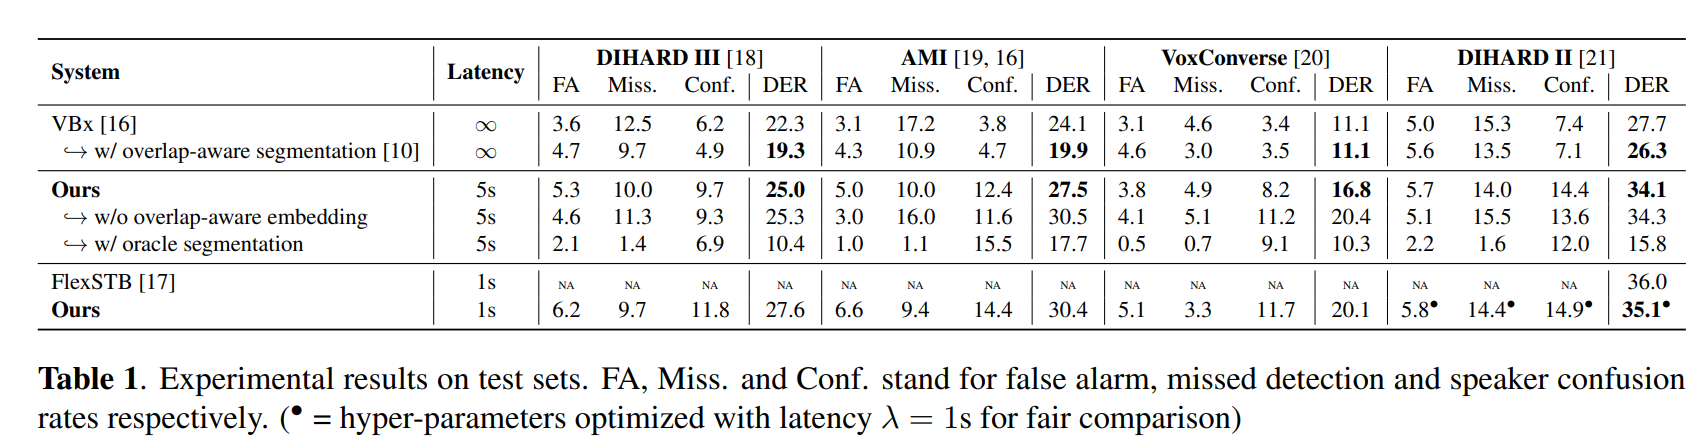

# Using pyannote one by one eval using loop

In [7]:
# single inialisations
wav_dir = os.path.join(data_dir,'wav/test')
rttm_dir = os.path.join(data_dir, 'rttms/test')
out_dir = os.path.join(data_dir, 'out')
os.makedirs(out_dir,exist_ok=True)

# config = PipelineConfig()  # For default parameters
config = PipelineConfig(
    step=0.5,
    latency=1.5,
    tau_active=0.507,
    rho_update=0.006,
    delta_new=1.057
)
pipeline = OnlineSpeakerDiarization(config)

metric = DiarizationErrorRate()
der2 = 0
ami_labels = []

# run loop over all the test set
for single_rttm in groundtruth_rttm_list:
    ami_label = single_rttm.split(sep="/")[-1]
    ami_label = ami_label[:-5] # remove .rttm from last
    ami_label_short = ami_label.split(sep=".")[0] # remove .rttm from last
    ami_labels.append(ami_label)
    
    groundtruth = load_rttm(single_rttm) # this is a dict for rttm db
    print(groundtruth)
    groundtruth = groundtruth[ami_label_short] # get groundtruth of particular label from dictionary
    
    # num of speakers not required to pass
#     num_speakers = Counter([l.split()[-1] for l in labels]).keys().__len__()

    # find the corresponding audio file according to rttm
    single_audio = [audio for audio in audio_list if ami_label in audio][0]
    
    ## -----Visualise data-----
    print("ami_label: ", ami_label)    
    # !cat {single_rttm} # view the sample groundtruth rttm file
    # print("labels: "labels, groundtruth)
    # print("num_speakers: ", num_speakers)   
    # print("single_audio: ", single_audio)

    # -----audio source-----
    audio_source = FileAudioSource(single_audio, config.sample_rate, config.duration, config.step)

    
    # -----Load model and diarize-----
    inference = RealTimeInference(output_path=out_dir, do_plot=False)
    inference(pipeline, audio_source)
    
    hypothesis = load_rttm(out_dir+'/'+ami_label+'.rttm') # this is generated above by diart
    hypothesis = hypothesis[ami_label] # get groundtruth of DEMO

    der = metric(groundtruth, hypothesis)
    print(f"Diarization error rate (DER) = {100 * der:.1f}%\n\n")



{'EN2002a': <pyannote.core.annotation.Annotation object at 0x7f995dede250>}
ami_label:  EN2002a.Mix-Headset


Streaming EN2002a.Mix-Headset: 100%|██████████| 4277/4277 [02:21<00:00, 30.20it/s]


Diarization error rate (DER) = 49.2%


{'EN2002b': <pyannote.core.annotation.Annotation object at 0x7f9930e3f8e0>}
ami_label:  EN2002b.Mix-Headset


Streaming EN2002b.Mix-Headset: 100%|██████████| 3565/3565 [02:00<00:00, 29.50it/s]


Diarization error rate (DER) = 43.5%


{'EN2002c': <pyannote.core.annotation.Annotation object at 0x7f995dc0ab80>}
ami_label:  EN2002c.Mix-Headset


Streaming EN2002c.Mix-Headset: 100%|██████████| 5936/5936 [03:23<00:00, 29.21it/s]


Diarization error rate (DER) = 29.4%


{'EN2002d': <pyannote.core.annotation.Annotation object at 0x7f9930e3f0d0>}
ami_label:  EN2002d.Mix-Headset


Streaming EN2002d.Mix-Headset: 100%|██████████| 4411/4411 [02:45<00:00, 26.70it/s]


Diarization error rate (DER) = 39.9%


{'ES2004a': <pyannote.core.annotation.Annotation object at 0x7f9930e3fac0>}
ami_label:  ES2004a.Mix-Headset


Streaming ES2004a.Mix-Headset: 100%|██████████| 2090/2090 [01:10<00:00, 29.56it/s]


Diarization error rate (DER) = 42.4%


{'ES2004b': <pyannote.core.annotation.Annotation object at 0x7f995de087f0>}
ami_label:  ES2004b.Mix-Headset


Streaming ES2004b.Mix-Headset: 100%|██████████| 4682/4682 [02:38<00:00, 29.45it/s]


Diarization error rate (DER) = 50.1%


{'ES2004c': <pyannote.core.annotation.Annotation object at 0x7f995dede9a0>}
ami_label:  ES2004c.Mix-Headset


Streaming ES2004c.Mix-Headset: 100%|██████████| 4660/4660 [02:38<00:00, 29.44it/s]


Diarization error rate (DER) = 40.4%


{'ES2004d': <pyannote.core.annotation.Annotation object at 0x7f995dedfa60>}
ami_label:  ES2004d.Mix-Headset


Streaming ES2004d.Mix-Headset: 100%|██████████| 4436/4436 [02:31<00:00, 29.30it/s]


Diarization error rate (DER) = 46.8%


{'IS1009a': <pyannote.core.annotation.Annotation object at 0x7f995de08c70>}
ami_label:  IS1009a.Mix-Headset


Streaming IS1009a.Mix-Headset: 100%|██████████| 1669/1669 [00:56<00:00, 29.30it/s]


Diarization error rate (DER) = 32.4%


{'IS1009b': <pyannote.core.annotation.Annotation object at 0x7f9930e3feb0>}
ami_label:  IS1009b.Mix-Headset


Streaming IS1009c.Mix-Headset: 100%|██████████| 3633/3633 [02:02<00:00, 29.59it/s]


Diarization error rate (DER) = 44.4%


{'IS1009d': <pyannote.core.annotation.Annotation object at 0x7f995dd9e0d0>}
ami_label:  IS1009d.Mix-Headset


Streaming IS1009d.Mix-Headset: 3881it [02:11, 29.50it/s]                          


Diarization error rate (DER) = 33.8%


{'TS3003a': <pyannote.core.annotation.Annotation object at 0x7f9930e3f670>}
ami_label:  TS3003a.Mix-Headset


Streaming TS3003a.Mix-Headset: 100%|██████████| 3003/3003 [01:42<00:00, 29.41it/s]


Diarization error rate (DER) = 56.1%


{'TS3003b': <pyannote.core.annotation.Annotation object at 0x7f995dd37130>}
ami_label:  TS3003b.Mix-Headset


Streaming TS3003b.Mix-Headset:  62%|██████▏   | 2719/4412 [01:32<00:57, 29.49it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
metric.__dict__

{'metric_name_': 'diarization error rate',
 'components_': {'confusion',
  'correct',
  'false alarm',
  'missed detection',
  'total'},
 'accumulated_': {'missed detection': 3601.8760000000193,
  'total': 30713.924000000006,
  'false alarm': 1037.8999999999878,
  'correct': 18789.268999999986,
  'confusion': 8322.778999999993},
 'results_': [('EN2002a',
   {'missed detection': 390.4620000000015,
    'total': 2530.2600000000025,
    'false alarm': 80.5740000000005,
    'correct': 1364.993999999996,
    'confusion': 774.8040000000019,
    'diarization error rate': 0.49237627753669694}),
  ('EN2002b',
   {'missed detection': 260.17299999999983,
    'total': 1943.4399999999996,
    'false alarm': 59.039999999999225,
    'correct': 1157.9669999999994,
    'confusion': 525.2999999999996,
    'diarization error rate': 0.4345454451899718}),
  ('EN2002c',
   {'missed detection': 517.8670000000002,
    'total': 3343.6399999999994,
    'false alarm': 40.7949999999956,
    'correct': 2400.3549999

In [10]:
# display in table
arr = np.asarray(metric.results_)[:,1]
# print("dict: ",arr)

df = pd.DataFrame.from_records(arr)
if 'item' not in df.columns:
    df['item'] = ami_labels
    # add mean summary
    df.loc['mean'] = df.mean()

# Getting the total absolute DER on test set
der2 = df['diarization error rate'].mean()
print(f"Total DER = {100 * der2:.1f}%")    

# saving the dataframe
df.to_csv(out_dir+'/ami_mix_headset_der46.csv')
df

Total DER = 42.6%


,missed detection,total,false alarm,correct,confusion,diarization error rate,item
0,390.46200,2530.26000,80.57400,1364.994000,774.804000,0.492376,EN2002a.Mix-Headset
1,260.17300,1943.44000,59.04000,1157.967000,525.300000,0.434545,EN2002b.Mix-Headset
2,517.86700,3343.64000,40.79500,2400.355000,425.418000,0.294314,EN2002c.Mix-Headset
3,548.52700,2675.89000,72.48700,1679.722000,447.641000,0.399364,EN2002d.Mix-Headset
4,132.82000,923.43000,23.41000,554.958000,235.652000,0.424377,ES2004a.Mix-Headset
5,174.24700,2233.05000,74.33500,1188.249000,870.554000,0.501169,ES2004b.Mix-Headset
6,143.69000,2244.47000,96.65900,1434.308000,666.472000,0.404025,ES2004c.Mix-Headset
7,204.79300,2006.77000,111.05100,1178.229000,623.748000,0.468211,ES2004d.Mix-Headset
8,75.25500,695.90000,31.15000,501.319000,119.326000,0.324373,IS1009a.Mix-Headset
9,159.22600,1982.97000,45.32700,1051.224000,772.520000,0.492732,IS1009b.Mix-Headset


## Add your model
Third-party segmentation and embedding models can be integrated seamlessly by subclassing SegmentationModel and EmbeddingModel

In [ ]:
import torch
from typing import Optional
from diart.models import EmbeddingModel
from diart.pipelines import PipelineConfig, OnlineSpeakerDiarization
from diart.sources import MicrophoneAudioSource
from diart.inference import RealTimeInference

class MyEmbeddingModel(EmbeddingModel):
    def __init__(self):
        super().__init__()
        self.my_pretrained_model = load("my_model.ckpt")
    
    def __call__(
        self,
        waveform: torch.Tensor,
        weights: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        return self.my_pretrained_model(waveform, weights)

config = PipelineConfig(embedding=MyEmbeddingModel())
pipeline = OnlineSpeakerDiarization(config)
mic = MicrophoneAudioSource(config.sample_rate)
inference = RealTimeInference("/out/dir")
inference(pipeline, mic)